Some of the ideas are taken from very good explorations in https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python and https://lstrln.wordpress.com/2017/09/13/predicting-house-prices-on-kaggle-a-gentle-introduction-to-data-science-part-i/.

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.stats import probplot
from IPython.display import display


In [2]:
pd.options.display.max_columns = None
%matplotlib inline

In [3]:
initial_train = pd.read_csv('train.csv')
initial_test = pd.read_csv('test.csv')

* outliers
* regression assumptions
* simple imputation of missings
* modelled imputation of missings ('lot' variables)
* merge small categories
* ordinal features

# Exploratory data analysis

## Our data structure

In [4]:
print("Shape of train dataframe: " + str(initial_train.shape))
print("Number of distinct Id values: " + str(initial_train.Id.nunique()))

Shape of train dataframe: (1460, 81)
Number of distinct Id values: 1460


The are 1460 observations with a target called 'SalePrice' and a unique 'Id' variable which can be dropped.

In [5]:
initial_train.drop('Id', axis=1, inplace=True)
initial_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


This is what the first few rows show us. While there are too many variables to go through at this stage, we can see there are a range of variables with missing values, as well as numerous categorical variables (as can be seen in the accompanying data_description.txt file).

In [6]:
col_types = initial_train.dtypes
col_types.groupby(col_types).size()

int64      34
float64     3
object     43
dtype: int64

A reasonable number of our features (37 excepting the target variable 'SalesPrice') are numerical, however 43 are not.

In [7]:
missing_values = initial_train.isnull().mean()
missing_values[(missing_values.index.isin(col_types[col_types==object].index)) & (missing_values>0)].sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [8]:
missing_values[(missing_values.index.isin(col_types[col_types!=object].index)) & (missing_values>0)].sort_values(ascending=False)

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
dtype: float64

There are 19 variables with missing values, only three of which are numeric. Most of them only have a small (less than 5% or so) percentage missing, whilst there are several others such as 'PoolQC' with the vast majority missing.

* Note that there appear to be three groups of variables which have missing values for their group's other variables when one of the group's variables is missing. These are related to the garage, basement, and masonary. However, the former two have multiple other variables in their group which have no missing values (e.g. 'BsmtFinSF1' and 'BsmtFinSF2', and 'GarageCars' and 'GarageArea'); we may be able to impute using this.
* There is a similar story for 'FireplaceQu' ('Fireplaces') and 'PoolQC' ('PoolArea') which have many missing values. Again we may be able to somewhat reliably impute using these, especially as large percentages of each are missing
* 'MiscFeature' is mostly missing. There is a category for 'none', but less than 4% have any of the five other specified categories so we'd likely need to assume these missing values also represent 'none'
* 'LotFrontage' also has a non-negligible number of missing entries. However, we may be able to see if there is a relationship with 'LotArea', 'LotConfig', and 'LotShape' which we may be able to use to model to estimate the missing values.
* 'Alley' is less clear; like 'MiscFeature' this may just be a case of setting them as 'NA'
* 'Fence' is similar to 'Alley'
* 'Electrical' has less than 0.1% missing, or one observation, meaning it would be best to either drop this observation or use the average value 

## A more detailed look

Now we understand the structure of our data a bit better, we can start looking at individual variables, and attempt to look at their individual distributions and correlations. 

### Dependent variable 'SalePrice'
It makes sense to start with the target variable.

In [9]:
print(col_types['SalePrice'])

int64


As expected (this is a regression problem!), we have numerical response variable. But what does the range of values look like?

In [10]:
initial_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

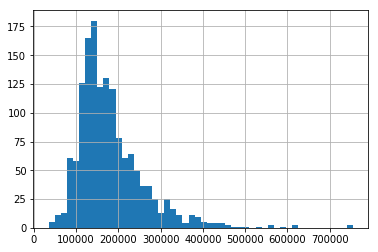

In [11]:
initial_train['SalePrice'].hist(bins=50)
plt.xlabel('Response')
plt.ylabel('Proportion')

This is definitely not normal (-ly distributed)! We might want to look into performing a log transformation on this a bit later if we have issues with linearity.

## Modifying the data and feature engineering
Before we go ahead and fit models to this data, first we need to do a couple of things:
1) Ensure that, especially for regression, key assumptions are met by the data to make sure the model is valid and reliable
2) Create new features to improve the model accuracy

### Dependent variable
One of the key assumptions of regression is that the distribution of errors is normal. Though not essential, it is also beneficial that the dependent variable is normal as it reduces the chances of other regression assumptions being violated (including linearity).

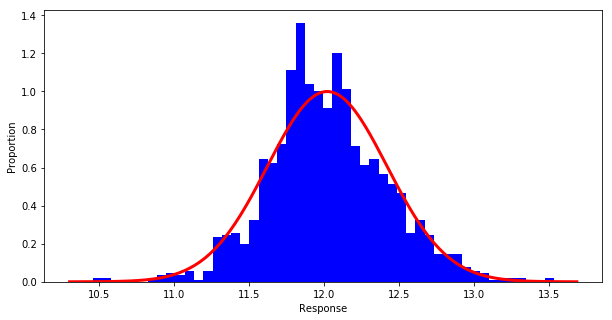

In [15]:
initial_train['LogSalePrice'] = np.log(initial_train['SalePrice'])

mean, std = norm.fit(initial_train['LogSalePrice'])

fig = plt.figure(figsize=(10, 5))
plt.hist(initial_train['LogSalePrice'], color='b', bins=50, density=True)
lim_xmin, lim_xmax = plt.xlim()
xvals = np.linspace(lim_xmin, lim_xmax, 200)
plt.plot(xvals, norm.pdf(xvals, mean, std), color='r', linewidth=3)
plt.xlabel('Logged response')
plt.ylabel('Proportion')
plt.show()

This is much closer to a normal distribution. As a result, we will consider this as our new dependent variable as we can do the inverse transform (exponentiation) to get the price back in terms of dollars. At this point I will also drop the original 'SalePrice' variable so we don't accidentally include it in our model.

In [13]:
initial_train.drop(columns='SalePrice', inplace=True)

### Relationship between variables

In [14]:
cols_numeric = initial_train.select_dtypes(include=np.number).columns
cols_cat = initial_train.select_dtypes(include=object).columns

#### Between 'SalePrice' and features
As I've already log transformed the variables, I will look at correlations using Spearman rank correlation, which is invariant under monotonic transforms.

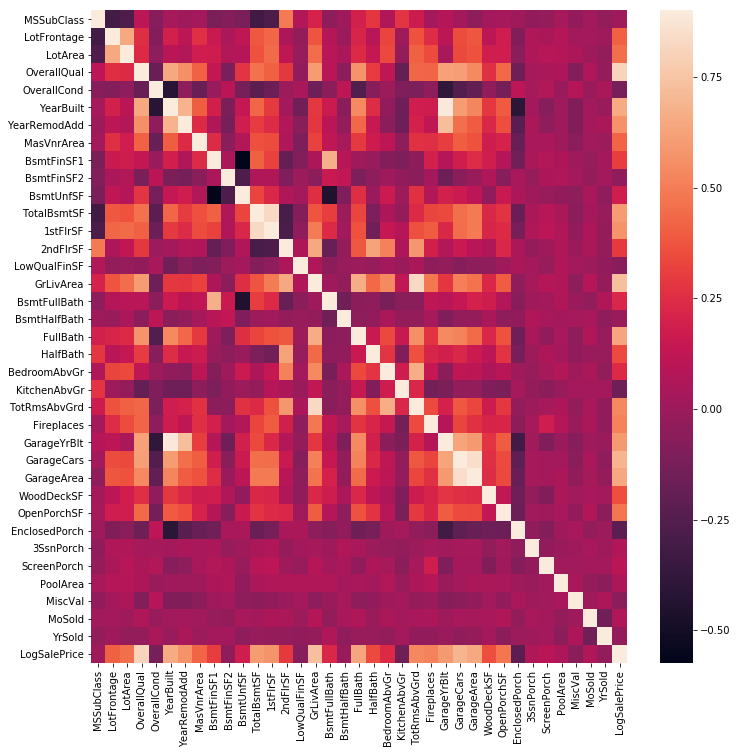

(37, 37)


In [73]:
fig = plt.figure(figsize=(12,12))
correlation_matrix = initial_train[cols_numeric].corr(method='spearman')
sns.heatmap(correlation_matrix, vmax=0.9)
plt.show()
correlation_matrix.head()
print(correlation_matrix.shape)

This shows us all numeric variables' correlations with each other, however it can be a little bit difficult to interpret.

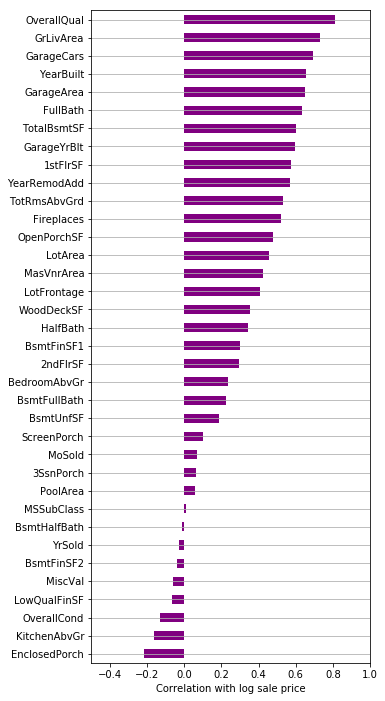

In [74]:
corr_with_target = correlation_matrix['LogSalePrice'].drop('LogSalePrice')

fig = plt.figure(figsize=(5,12)) 
corr_with_target.sort_values(ascending=True).plot(kind='barh', color='purple')
plt.xlim(-0.5, 1)
plt.xlabel('Correlation with log sale price')
plt.grid(axis='y')
plt.show()

Now is a good time to select some correlated feature variables to remove because the correlations between some of them may introduce multicollinearity which can impede the model results. For now, look at features with high correlation between themselves:

In [89]:
correlation_matrix_small = correlation_matrix.copy().drop(['LogSalePrice']).drop(columns=['LogSalePrice']).unstack()
correlation_matrix_small = correlation_matrix_small[(correlation_matrix_small>0.8) & (correlation_matrix_small!=1)]
correlation_matrix_small.sort_values(ascending=False)

GarageYrBlt   YearBuilt       0.890546
YearBuilt     GarageYrBlt     0.890546
GarageArea    GarageCars      0.853317
GarageCars    GarageArea      0.853317
1stFlrSF      TotalBsmtSF     0.829292
TotalBsmtSF   1stFlrSF        0.829292
TotRmsAbvGrd  GrLivArea       0.827874
GrLivArea     TotRmsAbvGrd    0.827874
dtype: float64

It appears from this that we might want to remove a couple of redundant variables. For example, 'GarageYrBlt' is strongly correlated with 'YearBuilt' so we will remove this variable (as it is itself slightly less correlated than 'YearBuilt' with the sales price). Similarly, we will drop 'GarageArea', '1stFlrSF', and 'TotRmsAbvGrd'. 

In [95]:
drop_numeric_cols = ['GarageYrBlt', 'GarageArea', '1stFlrSF', 'TotRmsAbvGrd']
initial_train.drop(columns=drop_numeric_cols, inplace=True)

Quite a few features have strong correlation with the house price. Before investigating some of the top ones further, we can check which are ordinal and which are continuous by assuming those with few unique values relative to the total observations are discrete.

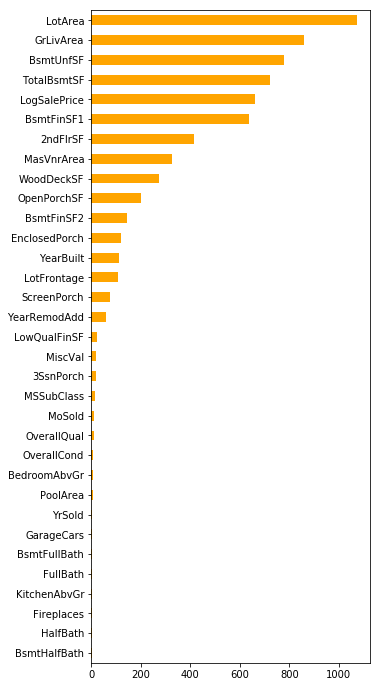

In [91]:
cols_numeric_uniques = initial_train[cols_numeric].nunique().sort_values()
fig = plt.figure(figsize=(5,12)) 
cols_numeric_uniques.plot(kind='barh', color='orange')
plt.show()

With the caveat that some continuous variables might appear to have low numbers due to potentially mostly being zero, we can see there are several variables which might actually be ordinal. Looking into 'OverallQual':

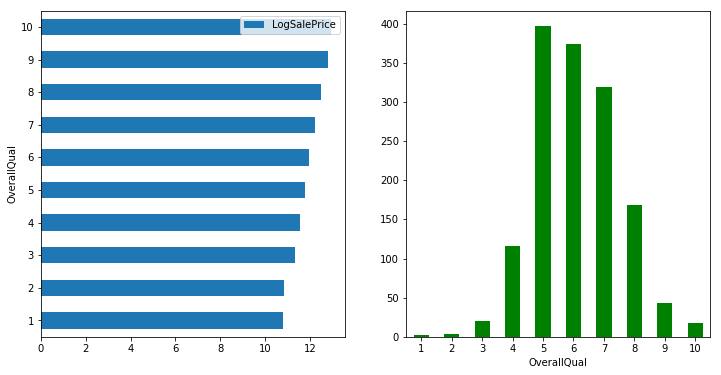

In [96]:
overqual_means = initial_train[['LogSalePrice','OverallQual']].groupby('OverallQual').mean()
overqual_counts = initial_train.groupby('OverallQual').size()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
overqual_means.plot(kind='barh', ax=ax1)
overqual_counts.plot(kind='bar', ax=ax2, rot=0, color='g')
plt.show()

Note that we are using the natural logarithm of the 'SalePrice' so differences may look slightly less clear than if we weren't, but it can clearly be seen that a higher overall quality is worth more!

We'll have a quick look at a couple more features:

'GrLivArea' appears to be a continuous variable, being near the top of the plot above the previous. Therefore a scatter plot would be good. I will also include two more plots, one the distribution of the feature and two a normal probability plot

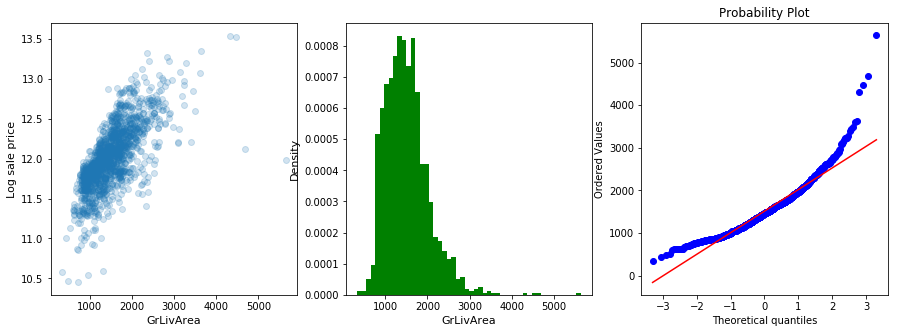

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(initial_train['GrLivArea'], initial_train['LogSalePrice'], alpha=0.2)
ax1.set_xlabel('GrLivArea', fontsize=11)
ax1.set_ylabel('Log sale price', fontsize=11)
ax2.hist(initial_train['GrLivArea'], density=True, bins=50, color='g')
ax2.set_xlabel('GrLivArea', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
probplot(initial_train['GrLivArea'], plot=ax3)
plt.show()

We can see there is very much a non-normal distribution of 'GrLivArea' as the horizontal line is not followed on the probability plot. Taking another logarithmic transform, this time of the feature, may improve the linear relationship between the feature and target. To check this, and allow the process to be quickly repeated for other continuous and ordinal variables, I define a simple function:

In [98]:
def log_transf_show(data, feature, target, datatype='cont', fsize=8, fplotsizex=12, fplotsizey=8):
    
    # If a continuous variable
    if datatype=='cont':
        new_feature_name = 'Log' + feature
        
        # The log of 0 is undefined so if any exist in the data, add a small constant to these
        if np.sum(data[feature]==0):
            print("One or more zero values - adding a small constant before transform")
            const = np.min(data[feature][data[feature]!=0])/1.1
        else:
            const = 0
        data[new_feature_name] = np.log(data[feature] + const)

        fig, axes = plt.subplots(2, 3, figsize=(fplotsizex, fplotsizey))

        # Untransformed variable relationship with target
        axes[0, 0].scatter(data[feature], data[target], alpha=0.2)
        axes[0, 0].set_xlabel(feature, fontsize=fsize)
        axes[0, 0].set_ylabel(target, fontsize=fsize)

        # Distribution of untransformed target variable
        axes[0, 1].hist(data[feature], density=True, bins=20, color='g')
        axes[0, 1].set_xlabel(feature, fontsize=fsize)
        axes[0, 1].set_ylabel('Density', fontsize=fsize)
        
        probplot(data[feature], plot=axes[0, 2])

        # Transformed variable relationship with target
        axes[1, 0].scatter(data[new_feature_name], data[target], alpha=0.2)
        axes[1, 0].set_xlabel(new_feature_name, fontsize=fsize)
        axes[1, 0].set_ylabel(target, fontsize=fsize)

        # Distribution of transformed target variable
        axes[1, 1].hist(data[new_feature_name], density=True, bins=20, color='g')
        axes[1, 1].set_xlabel(new_feature_name, fontsize=fsize)
        axes[1, 1].set_ylabel('Density', fontsize=fsize)

        probplot(data[new_feature_name], plot=axes[1, 2])
        
        plt.show()
        
    # If an ordinal/discrete variable
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fplotsizex, fplotsizey))
        means = data[[feature] + [target]].groupby(feature).mean()
        counts = data.groupby(feature).size()
        means.plot(kind='barh', ax=ax1)
        counts.plot(kind='bar', ax=ax2, rot=0, color='g')
        plt.show()
        
        #ax1.scatter(data[feature], data[target], alpha=0.2)
        #ax1.set_xlabel(feature, fontsize=fsize)
        #ax1.set_ylabel('Log sale price', fontsize=fsize)
        #ax2.hist(data[feature], density=True, bins=20, color='g')
        #ax2.set_xlabel(feature, fontsize=fsize)
        #ax2.set_ylabel('Density', fontsize=fsize)

        #plt.show()

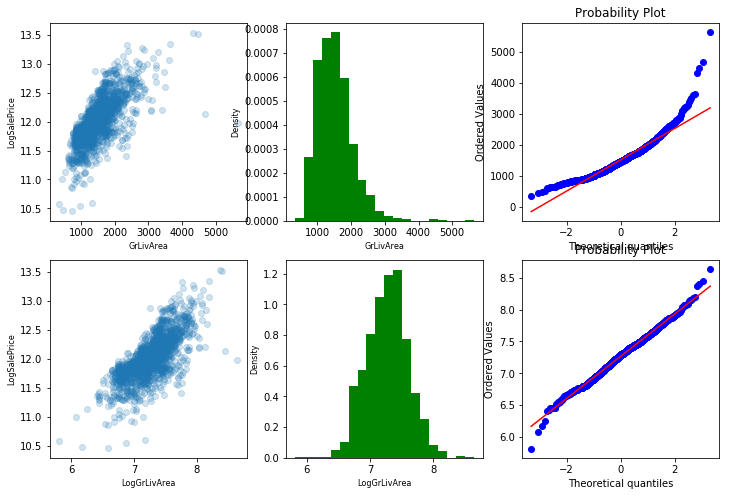

In [99]:
log_transf_show(initial_train, 'GrLivArea', 'LogSalePrice', datatype='cont')

As the second row shows a normal transform greatly improves the linearity of the relationship which should help avoid problems in the upcoming regression.

For 'BsmtUnfSF', things are a bit more tricky as there are lots of zero values which cannot be log transformed.

One or more zero values - adding a small constant before transform


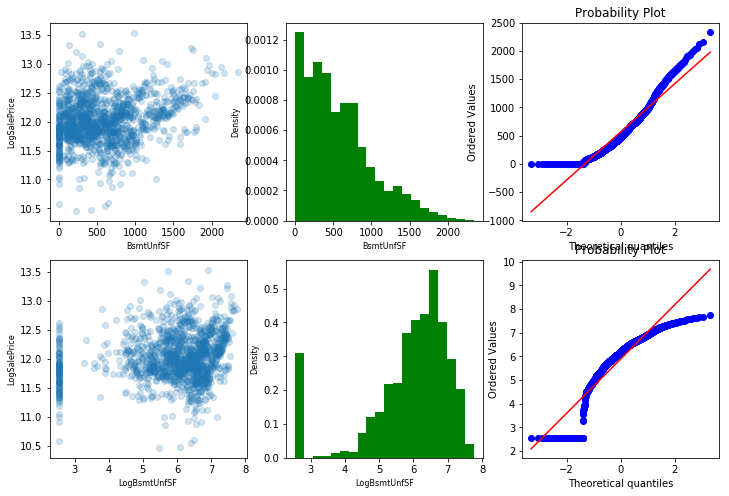

In [100]:
log_transf_show(initial_train, 'BsmtUnfSF', 'LogSalePrice', datatype='cont')

My initial plan to overcome the zero values was to add a small constant to each value of the feature. In fact, things seem to go awfully wrong with the probability plot!

An alternative approach in this situation would be to use a Box-Cox transform. This does require a 'shifting factor' to make non-zero values.

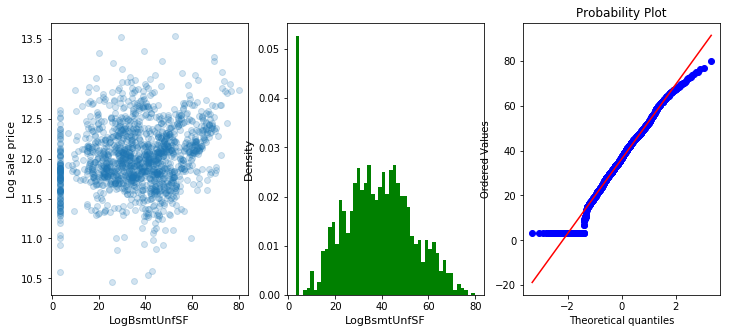

In [101]:
initial_train['LogBsmtUnfSF'], bc_lambda_BsmtUnfSF = boxcox(initial_train['BsmtUnfSF']+
                                                            initial_train['BsmtUnfSF'][initial_train['BsmtUnfSF']>0].min()/2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.scatter(initial_train['LogBsmtUnfSF'], initial_train['LogSalePrice'], alpha=0.2)
ax1.set_xlabel('LogBsmtUnfSF', fontsize=11)
ax1.set_ylabel('Log sale price', fontsize=11)
ax2.hist(initial_train['LogBsmtUnfSF'], density=True, bins=50, color='g')
ax2.set_xlabel('LogBsmtUnfSF', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
probplot(initial_train['LogBsmtUnfSF'], plot=ax3)
plt.show()

Normality is somewhat more noticeable, though I am still not completely happy with the process as it doesn't really address the zero problem, and may come back and have another look at this later. Editing the prior function to take this methodology into account:

In [46]:
def log_transf_show_bc(data, feature, target, datatype='cont', fsize=8, fplotsizex=12, fplotsizey=8):
    
    # If a continuous variable
    if datatype=='cont':
        new_feature_name = 'Log' + feature
        
        # The log of 0 is undefined so if any exist in the data, add a small constant to these
        if np.sum(data[feature]==0):
            data[new_feature_name], bc_lambda = boxcox(data[feature]+
                                                            data[feature][data[feature]>0].min()/2)
        else:
            data[new_feature_name] = np.log(data[feature])
            bc_lambda = None

        fig, axes = plt.subplots(2, 3, figsize=(fplotsizex, fplotsizey))

        # Untransformed variable relationship with target
        axes[0, 0].scatter(data[feature], data[target], alpha=0.2)
        axes[0, 0].set_xlabel(feature, fontsize=fsize)
        axes[0, 0].set_ylabel(target, fontsize=fsize)

        # Distribution of untransformed target variable
        axes[0, 1].hist(data[feature], density=True, bins=20, color='g')
        axes[0, 1].set_xlabel(feature, fontsize=fsize)
        axes[0, 1].set_ylabel('Density', fontsize=fsize)
        
        probplot(data[feature], plot=axes[0, 2])

        # Transformed variable relationship with target
        axes[1, 0].scatter(data[new_feature_name], data[target], alpha=0.2)
        axes[1, 0].set_xlabel(new_feature_name, fontsize=fsize)
        axes[1, 0].set_ylabel(target, fontsize=fsize)

        # Distribution of transformed target variable
        axes[1, 1].hist(data[new_feature_name], density=True, bins=20, color='g')
        axes[1, 1].set_xlabel(new_feature_name, fontsize=fsize)
        axes[1, 1].set_ylabel('Density', fontsize=fsize)

        probplot(data[new_feature_name], plot=axes[1, 2])
        
        plt.show()
        
        return bc_lambda
        
    # If an ordinal/discrete variable
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fplotsizex, fplotsizey))
        means = data[[feature] + [target]].groupby(feature).mean()
        counts = data.groupby(feature).size()
        means.plot(kind='barh', ax=ax1)
        counts.plot(kind='bar', ax=ax2, rot=0, color='g')
        plt.show()
        
        #ax1.scatter(data[feature], data[target], alpha=0.2)
        #ax1.set_xlabel(feature, fontsize=fsize)
        #ax1.set_ylabel('Log sale price', fontsize=fsize)
        #ax2.hist(data[feature], density=True, bins=20, color='g')
        #ax2.set_xlabel(feature, fontsize=fsize)
        #ax2.set_ylabel('Density', fontsize=fsize)

        #plt.show()
        
        return None

Note that some supposedly ordinal features should potentially be considered as categorical. These include 'GarageCars', 'YearBuilt'

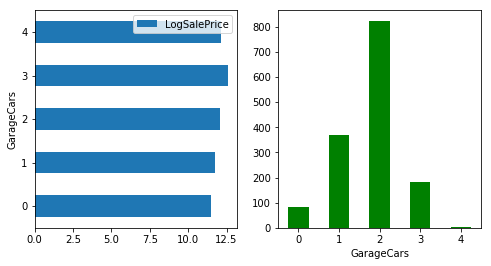

In [40]:
log_transf_show(initial_train, 'GarageCars', 'LogSalePrice', datatype='ord', fplotsizex=8, fplotsizey=4)

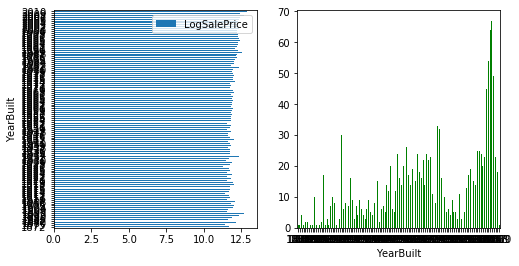

In [48]:
log_transf_show(initial_train, 'YearBuilt', 'LogSalePrice', datatype='ord', fplotsizex=8, fplotsizey=4)

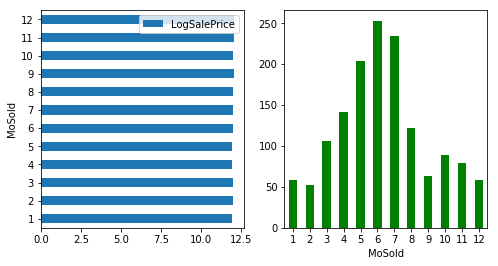

In [102]:
log_transf_show(initial_train, 'MoSold', 'LogSalePrice', datatype='ord', fplotsizex=8, fplotsizey=4)

In [ ]:




log_transf_show(initial_train, 'LotArea', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'BsmtUnfSF', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, '1stFlrSF', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'TotalBsmtSF', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'BsmtFinSF1', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'GarageArea', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, '2ndFlrSF', 'LogSalePrice', datatype='cont')
#log_transf_show(initial_train, 'MasVnrArea', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'WoodDeckSF', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'OpenPorchSF', 'LogSalePrice', datatype='cont')
log_transf_show(initial_train, 'EnclosedPorch', 'LogSalePrice', datatype='cont')

#### Between features

### Dealing with outliers

### Dealing with missing values

### Numeric variables (log transforming)

### Collapsing categories

### Feature engineering